<a href="https://colab.research.google.com/github/Trung0712/Text-Classification/blob/main/Text_Classification_using_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Text Classification**

##**1. Download Dataset from Github**

In [1]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 12.69 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (11/11), done.


In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

In [5]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [ ]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [ ]:
train_df.head(5)

,sentence,label
0,Quá thất_vọng cho 1 pub ở ngay trung_tâm saigo...,0
1,"Thấy review của foody đi ăn thử , thất_vọng vô...",0
2,Trc hay ăn đây lắm vì minh dễ ăn . Nhưng hôm_q...,0
3,"Hm = ) ) ) Ừm , chỗ này lần đầu mình uống nhưn...",0
4,Mình có order thức_ăn ở Zé 1 lần duy_nhất và m...,0


##**2. Preprocessing**

###**2.1. Language Detection**

In [2]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=37c18ea1c52c8cd64047e5f53eae1d8bd0b7caa2ab03249ed7d0758e4fa1cf8f
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [3]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [ ]:
train_df_vi, train_df_other = identify_vn(train_df)

In [ ]:
train_df_vi

,sentence,label
0,"Đến vào soft opening , nói thật_là chỉ ưng trâ...",0
1,Ăn một phần kem dừa với một viên kem dừa mà 30...,0
2,"Đi ăn vào đúng dịp 8/3 nên quán rất đông , như...",0
3,"Thấy mấy bạn khen quá nên đi ăn thử , thất_vọn...",0
4,"Không_gian : không nhỏ lắm , có bàn ngoài_trời...",0
...,...,...
29994,"Quán trang_trí bắt_mắt , nhạc nghe hay\n Nhân_...",1
29995,Lúc tầm giờ chiều có ghé vào cùng ba mình và đ...,1
29996,Vì không được vào khu nội tự nên cảm_thấy khá ...,1
29997,"Quán mới , mọi thứ mới , nhân_viên cũng mới và...",1


In [ ]:
train_df_other

,sentence,label
40,Lam gi co cho goi xe ... ... cho thi chat choi...,0
155,Fuf hug igv uvu ucy gyc jv yc yc 6 ycy g 7h kh...,0
629,We were at Buffet_Ganh last night and it was p...,0
630,The customer service was not too bad . But the...,0
669,"О с е н ь д о л г о г о т о в я т , а б с о л ...",0
...,...,...
29769,"Came here after dinner , parking and access wa...",1
29771,Nghe ban gioi thieu nen den quan uong thu . La...,1
29928,I went to eat udon with my vietnamese friends ...,1
29991,This place has a really # chill vibe to it and...,1


###**2.2. Preprocessing**

In [ ]:
import re
import string

def preprocess_text(text):

    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    text = " ".join(text.split())

    return text.lower()

In [ ]:
train_df_vi['sentence'][0]

'Có_lẽ do mình ăn đồ Hàn nhiều trong khu quận 7 & Tân_Bình nên quán này cứ như nấu không tới ý , ngoài_ra có những điểm không thích sau :\n • Quán bé xíu , không sạch_sẽ lắm\n • So với hình_ảnh trong menu thì đúng là " hình_ảnh rất mang tính minh_hoạ " - giá_cả nhìn có_vẻ vừa tầm nhưng chất_lượng lại tệ\n • Chả cá & soup không có gì đặc_sắc\n • Tokkobki phô_mai ăn được\n • Bulgogi ngọt như chè í và rất ít thịt , chỉ có miến với rau độn - giá 99k hơi cao\n • Nhân_viên lơ_đễnh kêu 2-3 thứ thì chỉ đem ra dc 1 thứ , nhắc_đi_nhắc_lại\n Bạn mình đến quán đầu_tiên và ngồi 1 mình , bạn nhân_viên khi order ngồi xuống ghế đối_diện và ghi làm nhỏ hơi giật_mình : )\n Chắc khó quay lại lần sau\n'

In [ ]:
preprocess_text(train_df_vi['sentence'][0])

'có lẽ do mình ăn đồ hàn nhiều trong khu quận tân bình nên quán này cứ như nấu không tới ý ngoài ra có những điểm không thích sau • quán bé xíu không sạch sẽ lắm • so với hình ảnh trong menu thì đúng là hình ảnh rất mang tính minh hoạ giá cả nhìn có vẻ vừa tầm nhưng chất lượng lại tệ • chả cá soup không có gì đặc sắc • tokkobki phô mai ăn được • bulgogi ngọt như chè í và rất ít thịt chỉ có miến với rau độn giá k hơi cao • nhân viên lơ đễnh kêu thứ thì chỉ đem ra dc thứ nhắc đi nhắc lại bạn mình đến quán đầu tiên và ngồi mình bạn nhân viên khi order ngồi xuống ghế đối diện và ghi làm nhỏ hơi giật mình chắc khó quay lại lần sau'

In [ ]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

<ipython-input-11-e21d2b59a2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


In [ ]:
train_df

,sentence,label
0,Có_lẽ do mình ăn đồ Hàn nhiều trong khu quận 7...,0
1,"Um thì view đẹp thiệt , nhưng thái_độ phục_vụ ...",0
2,Sa ́ ng nay mi ̀ nh co ́ đi ăn ba ́ nh cuô ́ n...,0
3,"- Quán bé , nhà_vệ_sinh thì lại rộng , ở khu_p...",0
4,"Hi_Admin ,\n Chỗ này đóng_cửa thay tên đổi chủ...",0
...,...,...
29995,"Nhà_hàng giá không rẻ mà đông cực , phải đặt c...",1
29996,Súp cua này đứng trước cổng truòng học Trần_Bô...,1
29997,"Cũng lâu rồi không ghé lại quán , kỳ này lên t...",1
29998,Hôm_nay có dịp ghé Watcha ăn và uống nhờ chuyế...,1


In [ ]:
valid_df

,sentence,label,preprocess_sentence
0,quán nhỏ nên ngồi và để xe có chút bất_tiện ~ ...,0,quán nhỏ nên ngồi và để xe có chút bất tiện đồ...
1,"Công_ty chọn tiệc tân niên ở đây , ban_đầu bên...",0,công ty chọn tiệc tân niên ở đây ban đầu bên n...
2,M thấy đồ uống chán qá . M gọi 1 match xay tru...,0,m thấy đồ uống chán qá m gọi match xay truyền ...
3,Mãi mới có quán gần trường để đi ăn . Dù quá h...,0,mãi mới có quán gần trường để đi ăn dù quá hơi...
4,"Thấy mấy đứa bạn kêu ngon nên zô ăn thử , có t...",0,thấy mấy đứa bạn kêu ngon nên zô ăn thử có thấ...
...,...,...,...
9995,Mình mới đến đây vài lần nhưng thấy có nhiều m...,1,mình mới đến đây vài lần nhưng thấy có nhiều m...
9996,Buổi_sáng dậy mà thèm bún_bò thì đây luôn là s...,1,buổi sáng dậy mà thèm bún bò thì đây luôn là s...
9997,"Bánh_tráng ở đây ngon , lạ_miệng nữa . Có nhiề...",1,bánh tráng ở đây ngon lạ miệng nữa có nhiều lo...
9998,Bữa mình ghé Aeon chơi xong vô lotteria ăn luô...,1,bữa mình ghé aeon chơi xong vô lotteria ăn luô...


In [ ]:
test_df

,sentence,label,preprocess_sentence
0,"Vừa ăn xong , đây là nhận_xét của mình .\n Nhâ...",0,vừa ăn xong đây là nhận xét của mình nhân viên...
1,"Bữa ghé ăn đây , thấy ăn cũng được xà_lách trộ...",0,bữa ghé ăn đây thấy ăn cũng được xà lách trộn ...
2,Thấy quán đông hiếu_kì nên ghé thử . Ăn xong r...,0,thấy quán đông hiếu kì nên ghé thử ăn xong rồi...
3,Bánh hong ngon như mong_đợi . Thấy cmt trên fo...,0,bánh hong ngon như mong đợi thấy cmt trên food...
4,"Tuy hơi khó tìm ra địa_chỉ , nhưng nem ở đây k...",0,tuy hơi khó tìm ra địa chỉ nhưng nem ở đây khá...
...,...,...,...
9995,Trà sữa ở đây thơm mùi trà và béo vị sữa . The...,1,trà sữa ở đây thơm mùi trà và béo vị sữa theo ...
9996,Không_gian quán ấm_áp thích lắm ý : ) ) ) nhân...,1,không gian quán ấm áp thích lắm ý nhân viên lẫ...
9997,"Không_gian đẹp , sang_trọng . Chị mình chuẩn_b...",1,không gian đẹp sang trọng chị mình chuẩn bị tổ...
9998,Really_Nice_Place to get a good meal for a ver...,1,really nice place to get a good meal for a ver...


###**2.3. EDA**

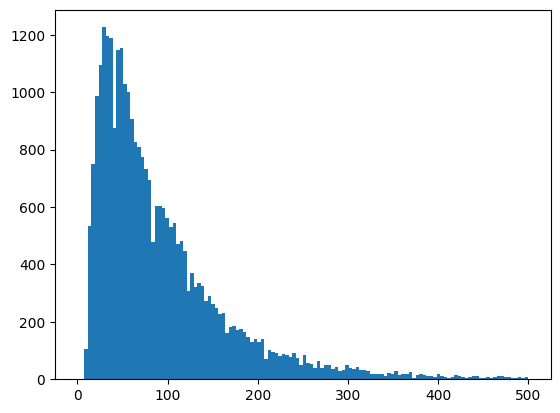

In [ ]:
import matplotlib.pyplot as plt

plt.hist([len(sentence.split()) for sentence in train_df_vi['preprocess_sentence']], bins=128, range=(0, 500))
plt.show()

In [ ]:
# count: words and vocabulary
from collections import Counter

words = []
[[words.append(word) for word in sentence.split()] for sentence in train_df_vi['preprocess_sentence']]
vocabulary = Counter(words)
len(vocabulary), len(words)

(17244, 2856797)

##**3. Text Representation**

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [ ]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [ ]:
tokenizer(train_df_vi['preprocess_sentence'][0])[:5]

['có', 'lẽ', 'do', 'mình', 'ăn']

In [ ]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
len(vocabulary)

10000

In [ ]:
# encode text

print(vocabulary(tokenizer(train_df_vi['preprocess_sentence'][0])))

[3, 537, 198, 2, 1, 45, 555, 46, 72, 368, 946, 1125, 143, 17, 6, 35, 232, 28, 597, 5, 127, 156, 154, 34, 3, 149, 178, 5, 57, 115, 1572, 6, 357, 384, 5, 274, 68, 66, 1572, 214, 29, 190, 468, 72, 247, 7, 245, 4, 190, 468, 12, 203, 171, 745, 2357, 30, 49, 106, 3, 263, 85, 392, 16, 122, 139, 20, 270, 1572, 219, 188, 1376, 5, 3, 75, 131, 438, 1572, 0, 371, 321, 1, 27, 1572, 2907, 119, 28, 556, 634, 8, 12, 179, 126, 69, 3, 1136, 29, 268, 2267, 30, 13, 50, 257, 1572, 26, 24, 887, 5707, 176, 215, 7, 69, 330, 34, 434, 215, 699, 22, 699, 20, 33, 2, 37, 6, 107, 298, 8, 84, 2, 33, 26, 24, 83, 244, 84, 457, 403, 381, 712, 8, 601, 79, 111, 50, 1803, 2, 142, 231, 128, 20, 40, 115]


In [ ]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

In [ ]:
print(next(iter(train_dataset)))

([3, 537, 198, 2, 1, 45, 555, 46, 72, 368, 946, 1125, 143, 17, 6, 35, 232, 28, 597, 5, 127, 156, 154, 34, 3, 149, 178, 5, 57, 115, 1572, 6, 357, 384, 5, 274, 68, 66, 1572, 214, 29, 190, 468, 72, 247, 7, 245, 4, 190, 468, 12, 203, 171, 745, 2357, 30, 49, 106, 3, 263, 85, 392, 16, 122, 139, 20, 270, 1572, 219, 188, 1376, 5, 3, 75, 131, 438, 1572, 0, 371, 321, 1, 27, 1572, 2907, 119, 28, 556, 634, 8, 12, 179, 126, 69, 3, 1136, 29, 268, 2267, 30, 13, 50, 257, 1572, 26, 24, 887, 5707, 176, 215, 7, 69, 330, 34, 434, 215, 699, 22, 699, 20, 33, 2, 37, 6, 107, 298, 8, 84, 2, 33, 26, 24, 83, 244, 84, 457, 403, 381, 712, 8, 601, 79, 111, 50, 1803, 2, 142, 231, 128, 20, 40, 115], 0)


In [ ]:
len(train_dataset)

29736

##**4. Dataloader**

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    encoded_sentences, labels, offsets = [], [], [0]
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)
        offsets.append(encoded_sentence.size(0))

    labels = torch.tensor(labels, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    encoded_sentences = torch.cat(encoded_sentences)
    return encoded_sentences.to(device), offsets.to(device), labels.to(device)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [ ]:
next(iter(train_dataloader))

(tensor([  2, 120,  37,  ...,   4, 124, 260]),
 tensor([    0,   244,   274,   417,   482,   576,   662,   719,   761,   784,
           831,  1019,  1074,  1243,  1288,  1331,  1344,  1360,  1416,  1440,
          1515,  1542,  1652,  1896,  2020,  2051,  2141,  2203,  2296,  2377,
          2430,  2486,  2584,  2752,  2804,  2946,  3039,  3059,  3086,  3120,
          3225,  3354,  3511,  3597,  3770,  4076,  4163,  4222,  4261,  4348,
          4368,  4456,  4504,  4557,  4672,  4775,  4921,  4956,  4998,  5234,
          5251,  5323,  5339,  5434,  5463,  5499,  5631,  5724,  5749,  5785,
          5815,  5852,  5883,  6034,  6233,  6256,  6330,  6373,  6572,  6655,
          6700,  6799,  6902,  6979,  7080,  7138,  7245,  7290,  7680,  7853,
          7899,  7925,  7965,  8084,  8156,  8295,  8339,  8415,  8556,  8714,
          8872,  9014,  9139,  9203,  9239,  9295,  9345,  9412,  9495,  9702,
          9733,  9790,  9953, 10043, 10467, 10527, 10639, 10746, 10796, 10864,
     

In [ ]:
encoded_sentences, offsets, labels = next(iter(train_dataloader))

In [ ]:
encoded_sentences.shape

torch.Size([11104])

##**4. Model**

**Embedding**

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class, seq_len):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.ft = nn.Flatten()
        self.fc = nn.Linear(seq_len*embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        ouput = self.ft(embedded)
        return self.fc(ouput)

In [ ]:
batch_size = 5
seq_len = 10
input = torch.ones([batch_size, seq_len], dtype=torch.int32)
input

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)

In [ ]:
num_class = 2
vocab_size = 5000
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class, seq_len)

In [ ]:
model

TextClassificationModel(
  (embedding): Embedding(5000, 100)
  (ft): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1000, out_features=2, bias=True)
)

In [ ]:
predictions = model(input)
predictions

tensor([[-0.0517,  1.9232],
        [-0.0517,  1.9232],
        [-0.0517,  1.9232],
        [-0.0517,  1.9232],
        [-0.0517,  1.9232]], grad_fn=<AddmmBackward0>)

**EmbeddingBag**

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, inputs, offsets):
        embedded = self.embedding(inputs, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

In [ ]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(10000, 100, mode='mean')
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
predictions = model(encoded_sentences, offsets)

In [ ]:
predictions

tensor([[ 8.0906e-02, -3.3078e-02],
        [ 7.5216e-02,  7.6704e-02],
        [ 1.0847e-01,  7.2861e-02],
        [-5.0523e-02,  5.2166e-02],
        [-1.3333e-02,  2.1172e-01],
        [-6.4176e-02,  9.2925e-02],
        [ 2.7008e-02,  1.3824e-01],
        [ 3.9476e-03,  6.2918e-02],
        [ 1.0791e-01,  2.3957e-02],
        [-1.6590e-01,  1.9178e-01],
        [ 1.5202e-01,  2.1842e-02],
        [ 3.2284e-03,  9.8168e-02],
        [ 2.2878e-02, -1.2369e-02],
        [-1.3142e-01,  9.3623e-02],
        [-2.0478e-01, -5.1081e-02],
        [-4.8734e-02,  1.7202e-02],
        [-2.9863e-02, -9.4589e-02],
        [-5.9666e-02,  1.2654e-01],
        [ 3.3456e-02,  2.5928e-01],
        [ 7.4628e-02,  1.3054e-01],
        [ 5.9113e-02, -6.3100e-02],
        [-3.3394e-02,  2.3732e-01],
        [-1.0687e-01,  4.7350e-02],
        [-6.4027e-02,  3.6666e-02],
        [-3.6169e-02,  8.0496e-02],
        [ 1.9498e-01,  1.2428e-01],
        [ 1.0739e-02,  3.5665e-02],
        [-4.7932e-02, -2.803

In [ ]:
learning_rate = 2e-5

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
loss = criterion(predictions, labels)

In [ ]:
loss

tensor(0.6952, device='cuda:0', grad_fn=<NllLossBackward0>)

##**5. Trainer**

In [ ]:
import time

def train(model, optimizer, criterion, train_dataloader, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, offsets, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predictions = model(inputs, offsets)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
epoch_acc, epoch_loss = train(model, optimizer, criterion, train_dataloader)

| epoch   0 |    25/  233 batches | accuracy    0.586
| epoch   0 |    50/  233 batches | accuracy    0.568
| epoch   0 |    75/  233 batches | accuracy    0.569
| epoch   0 |   100/  233 batches | accuracy    0.570
| epoch   0 |   125/  233 batches | accuracy    0.560
| epoch   0 |   150/  233 batches | accuracy    0.566
| epoch   0 |   175/  233 batches | accuracy    0.576
| epoch   0 |   200/  233 batches | accuracy    0.579
| epoch   0 |   225/  233 batches | accuracy    0.574


In [ ]:
epoch_acc, epoch_loss

(0.5955334987593052, 0.6800058698961151)

In [ ]:
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, offsets, labels) in enumerate(valid_dataloader):
            predictions = model(inputs, offsets)
            loss = criterion(predictions, labels)
            losses.append(loss)
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [ ]:
eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)

In [ ]:
eval_acc, eval_loss

(0.5742, tensor(0.6811, device='cuda:0'))

##**6. Training**

In [ ]:
num_class = len(set(train_df_vi['label']))
vocab_size = len(vocabulary)
embed_dim = 100
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

learning_rate = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 10
for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, epoch)
    eval_acc, eval_loss = evaluate(model, criterion, valid_dataloader)
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
        )
    )
    print("-" * 59)

| epoch   1 |    50/  233 batches | accuracy    0.671
| epoch   1 |   100/  233 batches | accuracy    0.806
| epoch   1 |   150/  233 batches | accuracy    0.829
| epoch   1 |   200/  233 batches | accuracy    0.837
-----------------------------------------------------------
| End of epoch   1 | Time:  2.36s | Train Accuracy    0.853 | Train Loss    0.458 | Valid Accuracy    0.837 | Valid Loss    0.392 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.853
| epoch   2 |   100/  233 batches | accuracy    0.858
| epoch   2 |   150/  233 batches | accuracy    0.862
| epoch   2 |   200/  233 batches | accuracy    0.867
-----------------------------------------------------------
| End of epoch   2 | Time:  2.39s | Train Accuracy    0.863 | Train Loss    0.358 | Valid Accuracy    0.843 | Valid Loss    0.378 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.865
| epoch   3 

##**7. Prediction**

In [ ]:
model = model.to('cpu')

In [ ]:
def predict(text):
    with torch.no_grad():
        encoded = torch.tensor(vocabulary(tokenizer(text)))
        output = model(encoded, torch.tensor([0]))
        return output.argmax(1).item()

In [ ]:
test_df.iloc[0]

sentence               Tối đà lạt trời rất lạnh nên mình rất thích đi...
label                                                                  1
preprocess_sentence    tối đà lạt trời rất lạnh nên mình rất thích đi...
Name: 0, dtype: object

In [ ]:
predict(test_df.iloc[0]['sentence'])

1

In [ ]:
# compute accuracy on test set

predictions, labels = [], []
for index, row in test_df.iterrows():
    sentence = row['preprocess_sentence']
    label = row['label']
    prediction = predict(sentence)
    predictions.append(prediction)
    labels.append(label)

sum(torch.tensor(predictions) == torch.tensor(labels))/len(labels)

tensor(0.8673)

##**8. Compare: BoW, TF-IDF**

###**8.1. BoW**

In [ ]:
import numpy as np

In [ ]:
train_labels = np.array(train_df_vi['label'].tolist())
test_labels = np.array(test_df['label'].tolist())

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

max_features = 10000
vectorizer = CountVectorizer(max_features=max_features)

train_sequences = vectorizer.fit_transform(train_df_vi['preprocess_sentence'])
test_sequences = vectorizer.transform(test_df['preprocess_sentence'])
vocab_size = len(vectorizer.vocabulary_)
vocab_size

10000

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_sequences, train_labels)

In [ ]:
logreg.score(test_sequences, test_labels)

0.8779

###**8.2. TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 10000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features)

train_sequences = tfidf_vectorizer.fit_transform(train_df_vi['preprocess_sentence'])
test_sequences = tfidf_vectorizer.transform(test_df['preprocess_sentence'])

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_sequences, train_labels)

LogisticRegression()

In [ ]:
logreg.score(test_sequences, test_labels)

0.8822